# Opinion Mining & Sentiment Analysis: Deep Learning Techniques

**Text Mining unit**

_Prof. Gianluca Moro^, Dott. Ing. Nicola Piscaglia° – DISI, University of Bologna_

^name.surname@unibo.it


°name.surname@bbs.unibo.it


**Bologna Business School** - Alma Mater Studiorum Università di Bologna

## Setup

Import external libraries (thus verifying they are correctly installed)

In [ ]:
%tensorflow_version 1.x

import gzip
import numpy as np
import pandas as pd
import gensim
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
%matplotlib inline

TensorFlow 1.x selected.


Using TensorFlow backend.


Check GPU and limit memory usage

In [ ]:
devices = tf.config.experimental_list_devices()

[print(device) for device in devices] # print all devices

#!nvidia-smi # check GPU configuration

if devices:
  try:
    tf.config.experimental.set_memory_growth = True
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    gpus = tf.config.experimental.list_physical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

/job:localhost/replica:0/task:0/device:CPU:0
/job:localhost/replica:0/task:0/device:XLA_CPU:0
/job:localhost/replica:0/task:0/device:XLA_GPU:0
/job:localhost/replica:0/task:0/device:GPU:0
1 Physical GPUs, 1 Logical GPUs


Define a utility function to download data files if they are not already present in working directory

In [ ]:
import os
from urllib.request import urlretrieve
def download(file, url):
    if not os.path.isfile(file):
        urlretrieve(url, file)

## Deep Learning and Neural Networks for Text Mining and Sentiment Analysis

_Deep learning_ denotes a general approach to machine learning employing **multi-layered models** to obtain **accurate representation of input data**: features are no longer extracted manually, but infered in the learning process

DL is mostly based on _neural networks_, very flexible learning models with arbitrary complexity

The use of DL and NN allows deep understanding of text without manually defining rules, lexicons, etc.

## TensorFlow and Keras

- **TensorFlow** by Google is one of the most used computation frameworks for deep learning
  - TF works by building a _computational graph_ where each node represents an operation between _tensors_ (N-dimensional arrays)
    - sums, products, derivatives, ...
  - a graph can run either on CPU or (where available) on GPU for accelerated parallel computation
- **Keras** provides an high-level API for building and training neural networks using TensorFlow as a backend
  - networks can be built simply by stacking different layers with many configurable (hyper)parameters
  - high-level commands are provided to train and evaluate networks on given datasets

## Dataset: Movie Reviews

We have a collection of user reviews extracted from IMDb (the _Internet Movie Database_) labeled as positive or negative

We want to train a model to understand the positive or negative orientation of any review

We start by loading the training dataset, containing 25,000 samples with two attributes
- `label` indicates the orientation of the review, can be "pos" or "neg"
- `text` contains the full text of the review

In [ ]:
download("imdb-train.csv.gz", "https://github.com/datascienceunibo/bbs-dl-lab-2019/raw/master/imdb-train.csv.gz")

In [ ]:
train_set = pd.read_csv("imdb-train.csv.gz", sep="\t", names=["label", "text"])

In [ ]:
train_set.shape

(25000, 2)

Let's view some rows of the dataset, after increasing the lenght of shown text

In [ ]:
pd.options.display.max_colwidth = 100

In [ ]:
train_set.head()

,label,text
0,pos,Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school l...
1,neg,Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a t...
2,pos,"If you like adult comedy cartoons, like South Park, then this is nearly a similar format about t..."
3,neg,Robert DeNiro plays the most unbelievably intelligent illiterate of all time. This movie is so w...
4,pos,"Bromwell High is nothing short of brilliant. Expertly scripted and perfectly delivered, this sea..."


Some HTML tags are present within reviews, specifically `<br />` to indicate newlines: we write a function which, applied on a text, replaces such tags with ASCII newline `\n`

In [ ]:
def strip_tags(text):
    return text.replace("<br />", "\n")

We apply the function to all texts in the dataset

In [ ]:
train_set["text"] = train_set["text"].apply(strip_tags)

Positive and negative reviews are evenly distributed

In [ ]:
train_set["label"].value_counts()

pos    12500
neg    12500
Name: label, dtype: int64

## Multi-Layer Perceptron

In their usual form, neural networks are composed by a stack of _densely connected_ layers of nodes: each node in a layer receives the output of all nodes of the underlying layer. Such networks are also known as _multi-layer perceptrons_.

A MLP receives a vector as input and its topmost layer produces a vector as output, an arbitrary number of _hidden layers_ can be inserted inbetween to produce intermediate representations of data

Let's start by training a neural network for sentiment classification feeded with vector space model representations of reviews

We initialize a vector space using tf.idf term weighting and filtering out very rare terms

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(min_df=3)

Such vector space is built upon the training reviews and their document-term matrix is produced

In [ ]:
train_dtm = vect.fit_transform(train_set["text"])
train_dtm

<25000x35852 sparse matrix of type '<class 'numpy.float64'>'
	with 3383253 stored elements in Compressed Sparse Row format>

Similarly to training matrices for scikit-learn models, this is a 2D array where each row (1st axis) is a training observation and each column (2nd axis) is a feature: each row is a possible input to the neural network

We extract the number of distinct terms in the vector space, used to define the structure of the neural network

In [ ]:
num_terms = len(vect.get_feature_names_out())

In [ ]:
num_terms

35852

We want our neural network to indicate in output the correct class of each review, either "pos" or "neg"

The common approach to classification with neural networks is to have one output node for each class and train them to output 1 on the right node and 0 on the others

For this, we must extract from the `label` column a "target" matrix, where each row contains the values which the network should give as output for each review
- `[1, 0]` for positive reviews
- `[0, 1]` for negative reviews

We define a function `make_target` which converts a given pos/neg labels series into a target matrix

In [ ]:
def make_target(labels):
    return pd.DataFrame({
        "pos": labels == "pos", # if the label is "pos" then return 1 else return 0
        "neg": labels == "neg" # if the label is "neg" then return 1 else 0
    }).astype(int)

We then apply it to the training set labels

In [ ]:
train_target = make_target(train_set["label"])

We obtain a matrix where each row is the expected network output, either `[1, 0]` (positive) or `[0, 1]` (negative)

In [ ]:
train_target.head()

,pos,neg
0,1,0
1,0,1
2,1,0
3,0,1
4,1,0


Let's define the structure of the neural network

We create a _sequential_ model, i.e. we define the network as a sequence of interconnected layers (alternatively, we could create non-linear structures by manually connecting layers to each other using Keras Functional API. To learn more, see: https://keras.io/guides/functional_api/)

In [ ]:
from keras.models import Sequential
model = Sequential()

In [ ]:
#Functional API version
# inputs = keras.Input(shape=(num_terms,))

In this first example we create a single-layered network, where inputs are directly connected to the output nodes

As discussed above, the output nodes must be 2, one for each class; we use the _softmax_ activation function to ensure that the output is a valid probability distribution
- we will never get a perfect `[1, 0]` as output in practice, but we will get outputs like `[0.99, 0.01]`

In the first layer (in this case the only one) we also have to specify with `input_dim` the size of input vectors, in this case the number of terms in the vector space

In [ ]:
from keras.layers import Dense
model.add(Dense(2, activation="softmax", input_dim=num_terms))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
# Functional API version
# outputs = keras.layers.Dense(2, activation="softmax", input_dim=num_terms)(inputs)
# model = keras.Model(inputs=inputs, outputs=outputs, name="my_model")

With `summary` we can analyze the structure of our network and get the count of trainable parameters

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2)                 71706     
Total params: 71,706
Trainable params: 71,706
Non-trainable params: 0
_________________________________________________________________


In this case we have 35,852×2 = 71,704 weights + 2 biases = 71,706 trainable parameters

After defining the network structure, we _compile_ it to provide some general settings of the network and initialize accordingly the underlying TensorFlow data structures

In [ ]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

- The _optimizer_ is the algorithm used to train the network: _Adam_ and other valid options are different variants of stochastic gradient descent (SGD), including learning rate decay, momentum, etc.
- The _loss_ is the measure to be minimized in the training process: the _cross entropy_ penalizes outputs which are not close to 1 on the correct class
- Additional _metrics_ can be computed for evaluation purposes: we use the accuracy, i.e. the percentage of correctly classified examples

We are now ready to train (_fit_) the network on given training examples, composed of inputs (tf.idf vectors) and target outputs (`[1, 0]` for positive reviews and `[0, 1]` for negative)

The training examples are shuffled and used to run SGD steps on _minibatches_ of a specified size (`batch_size`): this process is repeated for a given number of training _epochs_

`callbacks` parameters let us define a list of functions to be called by keras at the end of each epoch. This option is mainly used to implement some training logic (e.g. EarlyStopping) but if we runned out of memory we also could use it to call gc.collect() after each epoch in order to free some memory.

In [ ]:
# Garbage Collector library
import gc

# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

fit_history = model.fit(train_dtm, train_target, batch_size=200, epochs=10, callbacks=[GarbageCollectorCallback()])


Epoch 1/10
25000/25000 [==============================] - 5s 201us/step - loss: 0.6569 - accuracy: 0.8013
Epoch 2/10
25000/25000 [==============================] - 5s 203us/step - loss: 0.5872 - accuracy: 0.8645
Epoch 3/10
25000/25000 [==============================] - 4s 158us/step - loss: 0.5327 - accuracy: 0.8776
Epoch 4/10
25000/25000 [==============================] - 4s 159us/step - loss: 0.4890 - accuracy: 0.8865
Epoch 5/10
25000/25000 [==============================] - 4s 159us/step - loss: 0.4533 - accuracy: 0.8930
Epoch 6/10
25000/25000 [==============================] - 4s 159us/step - loss: 0.4234 - accuracy: 0.8999
Epoch 7/10
25000/25000 [==============================] - 4s 161us/step - loss: 0.3980 - accuracy: 0.9056
Epoch 8/10
25000/25000 [==============================] - 4s 159us/step - loss: 0.3762 - accuracy: 0.9110
Epoch 9/10
25000/25000 [==============================] - 4s 159us/step - loss: 0.3570 - accuracy: 0.9158
Epoch 10/10
25000/25000 [====================

During the training process we see how loss and accuracy measured on the training set vary, their evolution can also be obtained from the "history" object returned by `fit`

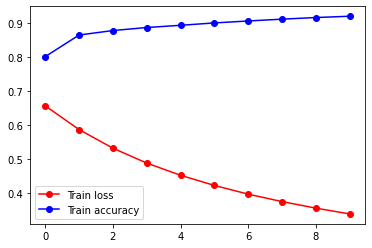

In [ ]:
plt.plot(fit_history.history["loss"], "ro-")
plt.plot(fit_history.history["accuracy"], "bo-")
plt.legend(["Train loss", "Train accuracy"]);

We can see in the plot how the loss progressively decreases and accuracy progressively increases through training epochs

To get the raw output given by the network for a given input, we use the `predict` method: let's see for example the output for the first training review (labeled positive)

In [ ]:
train_dtm[0]

<1x35852 sparse matrix of type '<class 'numpy.float64'>'
	with 86 stored elements in Compressed Sparse Row format>

In [ ]:
model.predict(train_dtm[0])

array([[0.59364957, 0.40635043]], dtype=float32)

We see that the first class (positive) has higher probability

We can directly get the predicted class index with `predict_classes`

In [ ]:
# model.predict_classes(train_dtm[0].toarray()) --> [0]

or...

In [ ]:
# Alternative Version working with Functional API / Tensorflow 2.0
prediction = model.predict(train_dtm[0])
print(prediction)

np.argmax(prediction, axis=-1)

[[0.59364957 0.40635043]]


array([0])

Let's now evaluate the network on a separate test set of labeled reviews, provided in the `imdb-test.csv.gz` file

In [ ]:
download("imdb-test.csv.gz", "https://github.com/datascienceunibo/bbs-dl-lab-2019/raw/master/imdb-test.csv.gz")

In [ ]:
test_set = pd.read_csv("imdb-test.csv.gz", sep="\t", names=["label", "text"])

In [ ]:
test_set.head(5)

,label,text
0,pos,I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit ...
1,neg,Once again Mr. Costner has dragged out a movie for far longer than necessary. Aside from the ter...
2,pos,"My boyfriend and I went to watch The Guardian.At first I didn't want to watch it, but I loved th..."
3,neg,This is a pale imitation of 'Officer and a Gentleman.' There is NO chemistry between Kutcher and...
4,pos,My yardstick for measuring a movie's watch-ability is if I get squirmy. If I start shifting posi...


Also in this dataset we have 25,000 reviews evenly distributed

In [ ]:
test_set["label"].value_counts()

pos    12500
neg    12500
Name: label, dtype: int64

As before, we apply the HTML strip function to reviews

In [ ]:
test_set["text"] = test_set["text"].apply(strip_tags)

We represent the test reviews in the vector space created on training reviews

In [ ]:
test_dtm = vect.transform(test_set["text"])
test_dtm

<25000x35852 sparse matrix of type '<class 'numpy.float64'>'
	with 3291409 stored elements in Compressed Sparse Row format>

We then convert pos/neg labels for test examples into target vectors

In [ ]:
test_target = make_target(test_set["label"])
test_target

,pos,neg
0,1,0
1,0,1
2,1,0
3,0,1
4,1,0
...,...,...
24995,0,1
24996,1,0
24997,0,1
24998,1,0


After processing the test set, we can fed it to the neural network for evaluation using the `evaluate` method

In [ ]:
model.evaluate(test_dtm, test_target)

25000/25000 [==============================] - 4s 157us/step


[0.3994659994697571, 0.8704400062561035]

The method reports the loss (first value) and the accuracy (second value) measured on the given test set: our final goal is to maximize the accuracy

Let's now introduce a _hidden layer_ in the network between input and output, for example a layer of 128 nodes with linear activation which receive input vectors

In [ ]:
model = Sequential()
model.add(Dense(128, input_dim=num_terms))

In [ ]:
# Functional API version
# inputs = keras.layers.Input(shape=(num_terms,))
# x = Dense(128)(inputs)

The output of these 128 will be fed to the output layer, composed as above by 2 nodes with softmax activation

In [ ]:
model.add(Dense(2, activation="softmax"))

In [ ]:
# Functional API Version
# outputs = Dense(2, activation="softmax")(x)
# model = keras.Model(inputs = inputs, outputs=outputs, name="model_with_hidden_layer")

The number of network parameters to be trained is now much higher

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 128)               4589184   
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 4,589,442
Trainable params: 4,589,442
Non-trainable params: 0
_________________________________________________________________


Let's compile the network as before

In [ ]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

To keep compute times limited, we fit this and subsequent networks running only 3 training epochs

In [ ]:
model.fit(train_dtm, train_target, batch_size=200, epochs=3, callbacks=[GarbageCollectorCallback()])

Epoch 1/3
25000/25000 [==============================] - 5s 182us/step - loss: 0.4118 - accuracy: 0.8514
Epoch 2/3
25000/25000 [==============================] - 4s 178us/step - loss: 0.1654 - accuracy: 0.9455
Epoch 3/3
25000/25000 [==============================] - 4s 178us/step - loss: 0.0891 - accuracy: 0.9768


Let's evaluate this new network on the same test set as before

In [ ]:
model.evaluate(test_dtm, test_target)

25000/25000 [==============================] - 4s 160us/step


[0.3168804416036606, 0.8714799880981445]

Thanks to the hidden layer we had a very slight improvement, despite the lower number of training epochs

To make the model more expressive, we have to introduce non-linearity in hidden layers: for example, we replicate the model above using sigmoid activation in the hidden layer

We can create the model more concisely by providing the list of layers to be stacked

In [ ]:
model = Sequential([
    Dense(128, activation="sigmoid", input_dim=num_terms),
    Dense(2, activation="softmax")
])
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
model.fit(train_dtm, train_target, batch_size=200, epochs=3, callbacks=[GarbageCollectorCallback()])

Epoch 1/3
25000/25000 [==============================] - 5s 183us/step - loss: 0.6293 - accuracy: 0.7565
Epoch 2/3
25000/25000 [==============================] - 4s 178us/step - loss: 0.4611 - accuracy: 0.8800
Epoch 3/3
25000/25000 [==============================] - 5s 180us/step - loss: 0.3205 - accuracy: 0.9107


In [ ]:
model.evaluate(test_dtm, test_target)

25000/25000 [==============================] - 5s 180us/step


[0.34417421193122866, 0.8758800029754639]

Finally, let's test a deep model with three non-linear hidden layers

In [ ]:
model = Sequential([
    Dense(256, activation="sigmoid", input_dim=num_terms),
    Dense(64, activation="sigmoid"),
    Dense(16, activation="sigmoid"),
    Dense(2, activation="softmax")
])
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 256)               9178368   
_________________________________________________________________
dense_7 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_8 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 34        
Total params: 9,195,890
Trainable params: 9,195,890
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(train_dtm, train_target, batch_size=200, epochs=3)

Epoch 1/3
25000/25000 [==============================] - 5s 206us/step - loss: 0.6837 - accuracy: 0.5892
Epoch 2/3
25000/25000 [==============================] - 5s 201us/step - loss: 0.4553 - accuracy: 0.8575
Epoch 3/3
25000/25000 [==============================] - 5s 201us/step - loss: 0.2041 - accuracy: 0.9279


In [ ]:
model.evaluate(test_dtm, test_target)

25000/25000 [==============================] - 4s 176us/step


[0.27963479736328123, 0.8828799724578857]

Once the right network structure has been found, you can also tune the regularization of your neural network adding Dropout layers or playing with L1/L2 reg values as in the following training example. Notice that due to the regularization effect, more training epoch could be needed.

In [ ]:
from keras import regularizers

model = Sequential([
    Dense(256, activation="sigmoid", input_dim=num_terms, kernel_regularizer=regularizers.L1L2(l1=1e-8, l2=1e-6)),
    Dense(64, activation="sigmoid"),
    Dense(16, activation="sigmoid"),
    Dense(2, activation="softmax")
])
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
model.fit(train_dtm, train_target, batch_size=200, epochs=3)

Epoch 1/3
25000/25000 [==============================] - 6s 238us/step - loss: 0.6869 - accuracy: 0.5955
Epoch 2/3
25000/25000 [==============================] - 6s 229us/step - loss: 0.4773 - accuracy: 0.8502
Epoch 3/3
25000/25000 [==============================] - 5s 219us/step - loss: 0.2334 - accuracy: 0.9213


In [ ]:
model.evaluate(test_dtm, test_target)

25000/25000 [==============================] - 5s 189us/step


[0.28912080417633057, 0.8863199949264526]

## Word Embedding

A _word embedding_ model is a dictionary mapping each known word to a **N-dimensional vector**

Such model is built by training a neural network on a bunch of text to predict the most likely word in a context defined by other words
- training is unsupervised: no labeling of text is needed


The resulting vector of each word somehow denotes its meaning: **semantically similar words are represented with similar vectors**. Moreover, operations between vectors can be used to **find words semantically related** to each other.

Word embedding models can be used to represent text in NLP tasks, including sentiment analysis

The **gensim** library provides means to represent and build word embedding models

## Training a Word2Vec model

We have a set of 5,000 movie reviews without any labeling: we can't train a sentiment classifier on them but we can train a word embedding model

We read the compressed text file `imdb-unsup-5k.txt.gz`, containing one review per line

In [ ]:
download("imdb-unsup-5k.txt.gz", "https://github.com/datascienceunibo/bbs-dl-lab-2019/raw/master/imdb-unsup-5k.txt.gz")

In [ ]:
with gzip.open("imdb-unsup-5k.txt.gz", "rt", encoding="utf8") as f: # open gzip file containing the dataset
    we_train_set = [strip_tags(line.strip()) for line in f] # for each line (review) of the file, strip the string and map tags

We have to preprocess each review by splitting text into tokens

gensim, the library used to train the word embedding model, provides a simple utility function for this
- alternatively any tokenization function can be used, e.g. `nltk.word_tokenize`

In [ ]:
from gensim.utils import simple_preprocess

In [ ]:
%%time

we_train_tokens = [simple_preprocess(text) for text in we_train_set] # we_train_tokens will be a matrix where the first axis contains each review tokens array while the second one represents the review tokens

# Wall time: time elapsed according to the computer's internal clock
# User-cpu time: the amount of time spent executing user-code 
# Sys cpu time: the amount of time spent in the kernel due to the need of privileged operations (like IO to disk)

CPU times: user 1.08 s, sys: 27.3 ms, total: 1.11 s
Wall time: 1.11 s


In [ ]:
we_train_set[0][:82]

'I admit, the great majority of films released before say 1933 are just not for me.'

In [ ]:
we_train_tokens[0][:8]

['admit', 'the', 'great', 'majority', 'of', 'films', 'released', 'before']

We can now use the token sequences to train the Word2Vec embedding model

The most important parameter is the size of the word vectors we want to obtain
- in the original Word2Vec paper 300 is indicated as a good value
- here we use 50 as a tradeoff between accuracy and efficiency

In [ ]:
wordvecs_size = 50

Other relevant parameters are
- the _window size_, i.e. the number of words before and after any word to consider as its context
- the minimum appearances of a term to be included in the model

We specify these options in the `Word2Vec` initializer, together with the set of token sequences used to train the model

In [ ]:
%%time
wv_model = gensim.models.Word2Vec(
    we_train_tokens,
    size=wordvecs_size,
    window=5,
    min_count=5
)

CPU times: user 14.4 s, sys: 115 ms, total: 14.5 s
Wall time: 8.6 s


Our Word2Vec model is now trained, we can get a reference to the word->vector mapping itself `wv` and drop the rest of the model object to free some memory

In [ ]:
wv = wv_model.wv
del wv_model

## Exploring the word embedding model

How many distinct terms are represented in the model?

In [ ]:
len(wv.vocab)

12070

Which are these terms? `index2word` is an ordered list with more common terms coming first

In [ ]:
wv.index2word[:10]

['the', 'and', 'of', 'to', 'is', 'in', 'it', 'this', 'that', 'as']

Let's see the vector of a word, e.g. "excellent"

In [ ]:
wv.word_vec("excellent")

array([-2.4980035 , -0.14969406, -1.8101636 ,  0.4116657 ,  0.31193823,
       -0.11041771, -0.5238655 ,  0.38178992,  2.162841  ,  1.6679823 ,
       -0.4137649 ,  0.13453671, -0.26821765, -0.28783432, -0.9977914 ,
        0.05385574, -0.9408156 ,  1.4003984 ,  0.62501556, -0.58989525,
        1.4667829 ,  0.13285218, -1.1394736 , -1.5052167 , -0.47079226,
        0.673453  , -0.24326678, -1.1836985 ,  0.07904789,  0.24690366,
       -0.96292096, -1.2462395 ,  0.8703872 ,  0.44818866,  0.02352279,
       -0.07354163, -2.3970087 , -2.0810559 , -0.22669289, -0.80077904,
       -0.73145676, -0.97802854, -0.26276267,  1.9163396 ,  0.10927846,
        0.84992033, -0.2662893 , -0.41152915,  0.71904075,  1.2974087 ],
      dtype=float32)

We can also compute and get (L2) normalized word vectors (for each vector the sum of the respective components squares will always be up to 1), used to compute cosine similarity

In [ ]:
wv.init_sims()   # compute and cache normalized vectors (using L2-Normalization)

In [ ]:
# True indicates to normalize the vector
wv.word_vec("excellent", True)

array([-0.34253526, -0.02052659, -0.24821617,  0.05644909,  0.0427741 ,
       -0.01514087, -0.07183433,  0.05235241,  0.29657656,  0.22871976,
       -0.05673693,  0.01844816, -0.03677897, -0.03946888, -0.13682076,
        0.00738489, -0.12900804,  0.19202767,  0.08570439, -0.08088856,
        0.20113057,  0.01821717, -0.15624872, -0.20640075, -0.06455673,
        0.0923463 , -0.03335762, -0.16231301,  0.01083933,  0.03385632,
       -0.13203919, -0.17088886,  0.11935063,  0.06145725,  0.00322553,
       -0.01008429, -0.32868648, -0.2853619 , -0.03108495, -0.10980571,
       -0.10029999, -0.13411081, -0.03603096,  0.2627754 ,  0.01498466,
        0.11654414, -0.03651455, -0.05643036,  0.09859746,  0.17790537],
      dtype=float32)

The word vector by itself doesn't give much information, but we can search for example which are the words with vectors most similar to this...

Let's use the `cosine_similarities` function to compute similarity between this vector and all the other ones, stored in the `vector` array

In [ ]:
similarities_to_excellent = wv.cosine_similarities(
    wv.word_vec("excellent"),
    wv.vectors
)

We obtain an array of cosine similarity scores that has a component for each word represented in the model

In [ ]:
similarities_to_excellent.shape

(12070,)

In [ ]:
similarities_to_excellent[:5]

array([ 0.06719482,  0.2600503 ,  0.09208315, -0.14226678,  0.2710683 ],
      dtype=float32)

Let's label them with the term they refer to and sort by descending values

In [ ]:
pd.Series(
    similarities_to_excellent,
    wv.index2word
).sort_values(ascending=False).head(10) # sort the values by descending similarity score and take the first 10

excellent      1.000000
outstanding    0.902485
brilliant      0.901978
terrific       0.891061
amazing        0.885479
fine           0.877729
superb         0.870027
directing      0.864877
fantastic      0.858256
impressive     0.855457
dtype: float32

In this way we found **other words** other than "excellent" with a **strong positive connotation**!

For this the model provides a `most_similar` method, which also removes the reference word from the results

In [ ]:
wv.most_similar("excellent")

[('outstanding', 0.9024852514266968),
 ('brilliant', 0.9019781351089478),
 ('terrific', 0.8910612463951111),
 ('amazing', 0.8854790329933167),
 ('fine', 0.8777288198471069),
 ('superb', 0.8700267672538757),
 ('directing', 0.8648768663406372),
 ('fantastic', 0.8582562208175659),
 ('impressive', 0.8554567098617554),
 ('wonderful', 0.8441264629364014)]

We can similarly see what happens with a strongly negative word, e.g. "terrible"

In [ ]:
wv.most_similar("terrible")

[('totally', 0.920531153678894),
 ('horrible', 0.9157000780105591),
 ('ok', 0.9080965518951416),
 ('scary', 0.880188524723053),
 ('boring', 0.8787528872489929),
 ('awful', 0.8708726167678833),
 ('cheesy', 0.8657823204994202),
 ('ridiculous', 0.8632988333702087),
 ('hilarious', 0.8592098355293274),
 ('amazing', 0.8530741333961487)]

Other strongly negative words are found!

Another powerful function of word embedding models is to find words with specific syntactic and semantic relationships using vector arithmetics

Consider the relationship _"man" is to "woman" as "actor" is to X_ where the model has to find out that X = "actress"

Word2Vec produces vectors in such a way that _"man" - "woman" = "actor" - X_, so we can find X as the term whose vector is closest to _"actor" + "woman" - "man"_

Let's produce the vector representation of X...

In [ ]:
composition = (wv.word_vec("actor", True)
             + wv.word_vec("woman", True)
             - wv.word_vec("man", True))

...and then find the words most similar to this composition

In [ ]:
pd.Series(
    wv.cosine_similarities(composition, wv.vectors),
    wv.index2word
).sort_values(ascending=False).head(10)

actor          0.911516
actress        0.906861
role           0.839133
bruce          0.812796
chaney         0.794021
davis          0.789406
performance    0.786315
played         0.785893
visconti       0.775002
star           0.768095
dtype: float32

Also in this case we can use `most_similar`, distinguishing words with positive and negative weight

In [ ]:
wv.most_similar(
    positive=["actor", "woman"],
    negative=["man"]
)

[('actress', 0.9068607091903687),
 ('role', 0.8391326069831848),
 ('bruce', 0.8127957582473755),
 ('chaney', 0.7940212488174438),
 ('davis', 0.789406418800354),
 ('performance', 0.7863155007362366),
 ('played', 0.7858928442001343),
 ('visconti', 0.7750020623207092),
 ('star', 0.7680947780609131),
 ('robin', 0.7602735757827759)]

According to randomness in the training process, the correct answer "actress" might be the most similar word or very close to it, but still the confidence of the model is limited

We proceed our analysis on a pretrained GloVe (_Global Vectors_) word embedding model, whose training procedure is similar to Word2Vec

We use a version trimmed down to the most common 100,000 terms of the 100d model trained on Wikipedia, available here: https://nlp.stanford.edu/projects/glove/

Arrays with words and vectors are provided in the `glove.npz` file

In [ ]:
download("glove.npz", "https://github.com/datascienceunibo/bbs-dl-lab-2019/raw/master/glove.npz")

In [ ]:
with np.load("glove.npz") as f:
    glove_words = f["words"]
    glove_vectors = f["vectors"]

We read the vector size from the loaded array

In [ ]:
wordvecs_size = glove_vectors.shape[1]
wordvecs_size

100

We then create the word embedding model from the words

In [ ]:
wv = gensim.models.KeyedVectors(wordvecs_size)
wv[glove_words.tolist()] = glove_vectors
wv.init_sims()

Searching on this model for the answer to _man : woman = actor : X_...

In [ ]:
wv.most_similar(
    positive=["actor", "woman"],
    negative=["man"]
)

[('actress', 0.9073609113693237),
 ('comedian', 0.6890829205513),
 ('actresses', 0.6826434135437012),
 ('screenwriter', 0.6554961204528809),
 ('starred', 0.6533135175704956),
 ('starring', 0.6514240503311157),
 ('actors', 0.6402771472930908),
 ('dancer', 0.6378583908081055),
 ('singer', 0.6346279382705688),
 ('filmmaker', 0.6279778480529785)]

...the correct answer "actress" is more dominant on the other ones

Other examples with multiple pairs: finding the plural of a singular word...

In [ ]:
wv.most_similar(
    positive=["mouse", "dogs", "cats"],
    negative=[         "dog",  "cat"]
)

[('mice', 0.710668683052063),
 ('rabbits', 0.681904673576355),
 ('rodents', 0.6771590709686279),
 ('rats', 0.6427716016769409),
 ('animals', 0.6243681907653809),
 ('monkeys', 0.6002902984619141),
 ('ferrets', 0.5910987854003906),
 ('mammals', 0.5888075828552246),
 ('foxes', 0.5750464200973511),
 ('raccoons', 0.5635854005813599)]

...and finding the capital of a State

In [ ]:
wv.most_similar(
    positive=["france", "rome",  "berlin"],
    negative=[          "italy", "germany"]
)

[('paris', 0.7584174871444702),
 ('cairo', 0.6146870851516724),
 ('london', 0.5959091186523438),
 ('versailles', 0.5937519669532776),
 ('vienna', 0.5896108150482178),
 ('brussels', 0.5775601863861084),
 ('petersburg', 0.5704914331436157),
 ('palace', 0.5681281089782715),
 ('sorbonne', 0.5556104183197021),
 ('strasbourg', 0.555298388004303)]

Another method provided by the model is `doesnt_match` finding the word which is the least related to the others in a given list

In [ ]:
wv.doesnt_match(["cat", "mouse", "dog", "keyboard", "frog"])

/usr/local/lib/python3.7/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'keyboard'

## Representing text with word embedding

We now see how to leverage the word embedding model in a neural network for sentiment classification

We start by tokenizing texts of training reviews

In [ ]:
%%time
train_tokens = [gensim.utils.simple_preprocess(text) for text in train_set["text"]]

CPU times: user 5.43 s, sys: 174 ms, total: 5.6 s
Wall time: 5.6 s


Let's see an example of tokenized review

In [ ]:
train_set["text"][0][:34]

'Bromwell High is a cartoon comedy.'

In [ ]:
train_tokens[0][:5]

['bromwell', 'high', 'is', 'cartoon', 'comedy']

We now convert these lists of text tokens into lists of indices of terms in the word embedding model, leaving out terms not present in the model

In [ ]:
train_indices = [
    [wv.vocab[word].index for word in text if word in wv.vocab] # for each token (word) in the review, that is present in our Word2Vec vocabulary, get its index in the Word2Vec vocabulary
    for text in train_tokens # i.e. for each tokenized review
]

For example the begin of the review above is now represented with...

In [ ]:
train_indices[0][:5] # [0] is the index of the first review, [:5] is used to get the first five word indexes of the first review

[152, 14, 7362, 2841, 20]

...which translated back into words would be... (notice that the first term was removed because not in the embedding model)

In [ ]:
[wv.index2word[i] for i in train_indices[0][:5]]

['high', 'is', 'cartoon', 'comedy', 'it']

Since we want to perform a review-level sentiment analysis, we have to find a way to represent each review using the respective word vectors.
As a first solution, we represent each review with the mean of normalized vectors of words contained in it: we obtain such vectors for all train reviews and stack them together in a matrix

In [ ]:
train_we_repr = np.vstack([wv.vectors_norm[indices].mean(0) for indices in train_indices]) # i.e. for each review indices, get the relative word2vec vectors, compute their means and stack the resulting vectors in a matrix.

# This way we now have a matrix that has a row per training set review and as many columns as the number of word vector features (100)
train_we_repr.shape

(25000, 100)

We then create a MLP network with one hidden layer accepting such vectors in input

In [ ]:
model = Sequential([
    Dense(128, activation="sigmoid", input_dim=wordvecs_size),
    Dense(2, activation="softmax")
])
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

As the input size of the network is much lower, so it is the number of parameters

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 128)               12928     
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 258       
Total params: 13,186
Trainable params: 13,186
Non-trainable params: 0
_________________________________________________________________


Training is much faster than before, so we can increment the epochs and reduce the batch size, thus making more SGD steps in each epoch

In [ ]:
model.fit(train_we_repr, train_target, batch_size=20, epochs=10)

Epoch 1/10
25000/25000 [==============================] - 3s 121us/step - loss: 0.6490 - accuracy: 0.6338
Epoch 2/10
25000/25000 [==============================] - 3s 118us/step - loss: 0.5673 - accuracy: 0.7267
Epoch 3/10
25000/25000 [==============================] - 3s 119us/step - loss: 0.5171 - accuracy: 0.7604
Epoch 4/10
25000/25000 [==============================] - 3s 121us/step - loss: 0.4924 - accuracy: 0.7713
Epoch 5/10
25000/25000 [==============================] - 3s 120us/step - loss: 0.4778 - accuracy: 0.7788
Epoch 6/10
25000/25000 [==============================] - 3s 120us/step - loss: 0.4693 - accuracy: 0.7824
Epoch 7/10
25000/25000 [==============================] - 3s 118us/step - loss: 0.4650 - accuracy: 0.7844
Epoch 8/10
25000/25000 [==============================] - 3s 121us/step - loss: 0.4593 - accuracy: 0.7884
Epoch 9/10
25000/25000 [==============================] - 3s 122us/step - loss: 0.4571 - accuracy: 0.7886
Epoch 10/10
25000/25000 [=====================

Let's preprocess test reviews as we did for training ones, thus extracting tokens and converting them to indices...

In [ ]:
test_tokens = [gensim.utils.simple_preprocess(text) for text in test_set["text"]]
test_indices = [
    [wv.vocab[word].index for word in text if word in wv.vocab]
    for text in test_tokens
]

...and obtaining means of word vectors for each review

In [ ]:
test_we_repr = np.vstack([wv.vectors_norm[indices].mean(0) for indices in test_indices])

We can now evaluate the network on the test reviews

In [ ]:
model.evaluate(test_we_repr, test_target)

25000/25000 [==============================] - 1s 48us/step


[0.45756174417495726, 0.7890400290489197]

The accuracy is not as good as before: with this representation we lose identity of the words in the documents other than their order

## Recurrent neural networks

MLPs are _feed-forward_ networks: their output at any time is only dependent from their input at the same time

On the other side, if we somehow introduce **memory** inside a network, we can make its output dependent from current as well as past inputs, thus we can process **sequential data**

_Recurrent_ neural networks include **cyclic connections** between nodes, making the output dependent from the state of the network at previous time steps and thus from previous inputs

### Sequential data

While an input example for a MLP must be represented with a vector of size S, an example for a recurrent NN is represented with a **sequence of vectors**, fed to the network in T subsequent time steps (T is equal for all examples)

Thus N input samples with input size S are no longer represented with a N×S array, but with a N×T×S array

Leveraging the word embedding model, we represent each review with the **sequence of word vectors** for the terms contained in it
- in this way, we consider both the identity of words (the vectors) and their order!

We start from the sequences of word indices `*_indices` (train_indices, test_indices) extracted above

We need to make all sequences of the same length (the T term above): we set a desired sequence size T, then we trim longer sequences to that size (taking the final T elements) and pad shorter sequences with null values: Keras' `pad_sequences` function does this
- larger T values would make training much slower

In [ ]:
from keras.preprocessing.sequence import pad_sequences
max_words = 200
train_seq = pad_sequences(train_indices, max_words)

In [ ]:
train_seq

array([[    0,     0,     0, ...,    12,    20, 75360],
       [    0,     0,     0, ...,    30,   541,  3442],
       [    0,     0,     0, ...,   219,   191,   219],
       ...,
       [    0,     0,     0, ..., 29080,  1075,    48],
       [  460,     4,    30, ...,   227,    30,  4254],
       [    0,     0,     0, ...,  1666,    13, 13664]], dtype=int32)

The size of the matrix is the number of samples times the sequence length, i.e. N×T

In [ ]:
train_seq.shape

(25000, 200)

### Building the network

Let's now create a neural network which gets such sequences as input

In [ ]:
model = Sequential()

We first insert an `Embedding` layer, which translates each received value into the word vector from the embedding model

We need to specify the size of input and output and the word vectors to be used, taking them from the model; we also specify `trainable=False` to "freeze" our pretrained word vectors and exclude them from training

In [ ]:
from keras.layers import Embedding
model.add(Embedding( # [1, 2, 3, ] --> [[2.23232, 2.4423, 223,2, ....], [], [] ]
    input_dim=len(wv.vocab),    # number of distinct vocabulary terms in Word2Vec model
    output_dim=wordvecs_size,   # size of word vectors (S)
    input_length=max_words,     # length of sequences (T)
    weights=[wv.vectors],       # pretrained Word2Vec vectors
    trainable=False
))

The output of this layer is a N×T×S tensor, we feed it to a recurrent layer which receives S-sized vectors for T time steps

_Gated Recurrent Units_ (GRU) are a simplified version of _Long Short-Term Memory_ (LSTM) units, which can potentially hold information in memory across many time steps; we use here a layer of 128 GRU cells

_Dropout_ randomly drops (sets to zero) a given ratio of input values at each time step: it is a technique to prevent model overfitting

In [ ]:
from keras.layers import GRU
model.add(GRU(128, dropout=0.2))

While producing 128 output values at each time step, the GRU layer by default only returns the outputs at the final steps, i.e. when the whole input sequence has been fed to the network, thus the output size of this layer is N×128 (the time dimension collapses)

We can now finalize the network with the output layer, which receives the output of the GRU layer

In [ ]:
model.add(Dense(2, activation="softmax"))

The model summary gives a recap of shapes of data across network layers other than parameters

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 100)          10000000  
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               87936     
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 258       
Total params: 10,088,194
Trainable params: 88,194
Non-trainable params: 10,000,000
_________________________________________________________________


We can now compile the network and train it on the padded sequences of word indices
- training of RNNs is quite slow, we again limit training to 3 epochs

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(train_seq, train_target, batch_size=200, epochs=3)

Epoch 1/3
25000/25000 [==============================] - 23s 919us/step - loss: 0.6094 - accuracy: 0.6546
Epoch 2/3
25000/25000 [==============================] - 22s 898us/step - loss: 0.4540 - accuracy: 0.7878
Epoch 3/3
25000/25000 [==============================] - 22s 900us/step - loss: 0.3959 - accuracy: 0.8221


Let's now obtain the padded sequences also for the test reviews...

In [ ]:
test_seq = pad_sequences(test_indices, max_words)

In [ ]:
test_seq

array([[    0,     0,     0, ...,   106,    81,   924],
       [    0,     0,     0, ...,    29,  1152,     6],
       [    0,     0,     0, ...,    20,    83,    94],
       ...,
       [    0,     0,     0, ...,   260,  1174, 12565],
       [    0,     0,     0, ...,  5989,  2926, 25495],
       [    0,     0,     0, ...,  1005,    36,  5466]], dtype=int32)

...and use them to evaluate the model

In [ ]:
model.evaluate(test_seq, test_target)

25000/25000 [==============================] - 60s 2ms/step


[0.3464177102565765, 0.8486800193786621]

We have got an higher accuracy than the previous solution, thanks to the reviews representation as word sequences and the memory capability of the GRU network

## Cross domain classification

We trained our network on reviews of movies and tested its ability to classify sentiment in reviews of movies

Can we successfully apply our model to reviews pertaining to a different domain?

The `yelp-test-10k.csv.gz` file contains 10,000 labeled user reviews about restaurants extracted from Yelp

In [ ]:
download("yelp-test-10k.csv.gz", "https://github.com/datascienceunibo/bbs-dl-lab-2019/raw/master/yelp-test-10k.csv.gz")

In [ ]:
xdom_set = pd.read_csv("yelp-test-10k.csv.gz", sep="\t", names=["label", "text"])

In [ ]:
xdom_set.head(5)

,label,text
0,pos,My wife took me here on my birthday for breakfast and it was excellent. The weather was perfec...
1,neg,U can go there n check the car out. If u wanna buy 1 there? That's wrong move! If u even want a...
2,pos,"I have no idea why some people give bad reviews about this place. It goes to show you, you can ..."
3,neg,Disgusting! Had a Groupon so my daughter and I tried it out. Very outdated and gaudy 80's sty...
4,pos,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!! It's very convenient and surrounded by a lot of..."


In [ ]:
xdom_set["label"].value_counts()

pos    5000
neg    5000
Name: label, dtype: int64

We apply the same preprocessing steps we applied above

In [ ]:
xdom_set["text"] = xdom_set["text"].apply(strip_tags)
xdom_tokens = [gensim.utils.simple_preprocess(text) for text in xdom_set["text"]]
xdom_indices = [
    [wv.vocab[word].index for word in text if word in wv.vocab]
    for text in xdom_tokens
]
xdom_seq = pad_sequences(xdom_indices, max_words)
xdom_target = make_target(xdom_set["label"])

In [ ]:
model.evaluate(xdom_seq, xdom_target)

10000/10000 [==============================] - 23s 2ms/step


[0.3851295549869537, 0.850600004196167]

The network is fairly accurate, although it was trained on reviews of a different domain

Can we further improve this?

## Fine tuning the network

In the `yelp-train-2k.csv.gz` we have a set of 2,000 labeled Yelp reviews which can be used for training

We would like to make use of these in-domain reviews, without throwing away the model trained on the richer set of cross-domain reviews

We can "tune" the trained model with an additional training run on the new set of reviews, thus making it more oriented to the new domain and still using knowledge from the other

Let's load and view a summary of the file...

In [ ]:
download("yelp-train-2k.csv.gz", "https://github.com/datascienceunibo/bbs-dl-lab-2019/raw/master/yelp-train-2k.csv.gz")

In [ ]:
tune_set = pd.read_csv("yelp-train-2k.csv.gz", sep="\t", names=["label", "text"])

In [ ]:
tune_set.head(5)

,label,text
0,pos,Great local yoga studio. Had flexible hours like early morning and late night to fit any schedu...
1,neg,"I've been craving a good roast beef sandwich for a few days now, and finally had the chance to ..."
2,pos,"Super tasty, love the cozy atmosphere, excellent and friendly service! The naan was a bit thin..."
3,neg,"After waiting 4 days to get an appointment, Flores was a no show and didn't even bother to call."
4,pos,I have had my kitty Miller for 8 years. She has never been to any other vet. I like this place...


In [ ]:
tune_set["label"].value_counts()

pos    1000
neg    1000
Name: label, dtype: int64

...and apply the usual preprocessing steps

In [ ]:
tune_set["text"] = tune_set["text"].apply(strip_tags)
tune_tokens = [gensim.utils.simple_preprocess(text) for text in tune_set["text"]]
tune_indices = [
    [wv.vocab[word].index for word in text if word in wv.vocab]
    for text in tune_tokens
]
tune_seq = pad_sequences(tune_indices, max_words)
tune_target = make_target(tune_set["label"])

We now repeat the model training process on this set of reviews: the process is very fast due to the limited size of the dataset

In [ ]:
model.fit(tune_seq, tune_target, epochs=5, batch_size=200)

Epoch 1/5
2000/2000 [==============================] - 2s 891us/step - loss: 0.3954 - accuracy: 0.8165
Epoch 2/5
2000/2000 [==============================] - 2s 878us/step - loss: 0.3156 - accuracy: 0.8670
Epoch 3/5
2000/2000 [==============================] - 2s 851us/step - loss: 0.2867 - accuracy: 0.8785
Epoch 4/5
2000/2000 [==============================] - 2s 857us/step - loss: 0.2718 - accuracy: 0.8875
Epoch 5/5
2000/2000 [==============================] - 2s 876us/step - loss: 0.2512 - accuracy: 0.9005


Let's now repeat the evaluation on the Yelp test set loaded before

In [ ]:
model.evaluate(xdom_seq, xdom_target)

10000/10000 [==============================] - 23s 2ms/step


[0.2260189118742943, 0.9085000157356262]

We successfully boosted the model accuracy, combining even limited knowledge of the target domain with large knowledge extracted from a different domain

## Introduction to the Transformer
The transformers library is an open-source, community-based repository to train, use and share models based on 
the Transformer architecture [(Vaswani & al., 2017)](https://arxiv.org/abs/1706.03762) such as Bert [(Devlin & al., 2018)](https://arxiv.org/abs/1810.04805),
Roberta [(Liu & al., 2019)](https://arxiv.org/abs/1907.11692), GPT2 [(Radford & al., 2019)](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf),
XLNet [(Yang & al., 2019)](https://arxiv.org/abs/1906.08237), etc. 

Along with the models, the library contains multiple variations of each of them for a large variety of 
downstream-tasks like **Named Entity Recognition (NER)**, **Sentiment Analysis**, 
**Language Modeling**, **Question Answering** and so on.

### Before Transformer

Back to 2017, most of the people using Neural Networks when working on Natural Language Processing were relying on 
sequential processing of the input through [Recurrent Neural Network (RNN)](https://en.wikipedia.org/wiki/Recurrent_neural_network).

![rnn](http://colah.github.io/posts/2015-09-NN-Types-FP/img/RNN-general.png)   

RNNs were performing well on large variety of tasks involving sequential dependency over the input sequence. 
However, this sequentially-dependent process had issues modeling very long range dependencies and 
was not well suited for the kind of hardware we're currently leveraging due to bad parallelization capabilities. 

Some extensions were provided by the academic community, such as Bidirectional RNN ([Schuster & Paliwal., 1997](https://www.researchgate.net/publication/3316656_Bidirectional_recurrent_neural_networks), [Graves & al., 2005](https://mediatum.ub.tum.de/doc/1290195/file.pdf)), 
which can be seen as a concatenation of two sequential process, one going forward, the other one going backward over the sequence input.

![birnn](https://miro.medium.com/max/764/1*6QnPUSv_t9BY9Fv8_aLb-Q.png)


And also, the Attention mechanism, which introduced a good improvement over "raw" RNNs by giving 
a learned, weighted-importance to each element in the sequence, allowing the model to focus on important elements.

![attention_rnn](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2017/08/Example-of-Attention.png)  

### Then comes the Transformer  

The Transformers era originally started from the work of [(Vaswani & al., 2017)](https://arxiv.org/abs/1706.03762) who
demonstrated its superiority over [Recurrent Neural Network (RNN)](https://en.wikipedia.org/wiki/Recurrent_neural_network)
on translation tasks but it quickly extended to almost all the tasks RNNs were State-of-the-Art at that time.

One advantage of Transformer over its RNN counterpart was its non sequential attention model. Remember, the RNNs had to
iterate over each element of the input sequence one-by-one and carry an "updatable-state" between each hop. With Transformer, the model is able to look at every position in the sequence, at the same time, in one operation.

For a deep-dive into the Transformer architecture, [The Annotated Transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html#encoder-and-decoder-stacks) 
will drive you along all the details of the paper.

![transformer-encoder-decoder](https://nlp.seas.harvard.edu/images/the-annotated-transformer_14_0.png)

### BERT
For the rest of this introduction and some summarisation tasks, we will use the [BERT (Devlin & al., 2018)](https://arxiv.org/abs/1810.04805) architecture, as it's one of the most powerful for text processing and there are plenty of content about it
over the internet, it will be easy to dig more over this architecture if you want to. 

BERT was trained on a large text corpus, which gives architecture/model the ability to better understand the language and to learn variability in data patterns and generalizes well on several NLP tasks. As it is bidirectional that means BERT learns information from both the left and the right side of a token’s context during the training phase.

One key point of this model is that it can be used to generate **contextual** word embeddings: as opposed to Word2Vec and GloVe each token is represented differently based on the context. For instance, in BERT the word "bank" is represented with two different vectors for the sentences "open a bank account" and "on the river bank" as they have different meanings. Instead W2C and GloVe are context-free representations, so they would represent "bank" with the same vector for all the sentences in the corpus.

BERT is mostly composed by Encoder blocks from the Transformer architecture that let BERT achieve high performance in language modeling/understanding tasks.

<img src="https://humboldt-wi.github.io/blog/img/seminar/bert/bert_architecture.png"></img>

This model is first pre-trained in two ways: 

1) First, it is (pre)trained on large corpora of text to solve a LM task (predicting masked words in sequences of tokens); 
<img src="https://jalammar.github.io/images/BERT-language-modeling-masked-lm.png"></img>

2) To make BERT better at handling relationships between multiple sentences, the pre-training process includes an additional task: Given two sentences (A and B), is B likely to be the sentence that follows A, or not?
<img src="https://jalammar.github.io/images/bert-next-sentence-prediction.png"></img>

Finally BERT can be fine-tuned for downstream tasks, as sentiment classification, adding a classification (usually linear) layer on top of the model.

### Getting started with transformers



The transformers library allows you to benefits from large, pretrained language models without requiring a huge and costly computational
infrastructure. Most of the State-of-the-Art models are provided directly by their author and made available in the library 
in PyTorch and TensorFlow in a transparent and interchangeable way. 

You will need to install the transformers library (if not already loaded). You can do so with this command:

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
from transformers import AutoModel, AutoTokenizer, BertTokenizer

torch.set_grad_enabled(False) # we initially do not train any model so we disable gradient calculation

In [ ]:
# Store the model we want to use
MODEL_NAME = "bert-base-uncased"

# We need to create the model and tokenizer
model = AutoModel.from_pretrained(MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


With only the above two lines of code, you're ready to use a BERT pre-trained model. 
The tokenizers will allow us to map a raw textual input to a sequence of integers representing our textual input
in a way the model can manipulate. Since we will be using a PyTorch model, we ask the tokenizer to return to us PyTorch tensors.

We can visualize this process graphically and then via code:
<img src="https://jalammar.github.io/images/distilBERT/bert-distilbert-tokenization-2-token-ids.png" />

You may have noticed that the word "rumination" has been splitted into two tokens (rum, ##ination). This is because BERT uses what is called a WordPiece tokenizer. It works by splitting words either into the full forms (e.g., one word becomes one token) or into word pieces — where one word can be broken into multiple tokens.

An example of where this can be useful is where we have multiple forms of words. For example:

| Word          | Token(s)                           |
| ------------- | ---------------------------------- |
| surf          | \['surf'\]                         |
| surfing       | \['surf', '##ing'\]                 |
| surfboarding  | \['surf', '##board', '##ing'\]       |
| surfboard     | \['surf', '##board'\]               |
| snowboard     | \['snow', '##board'\]               |
| snowboarding  | \['snow', '##board', '##ing'\]       |
| snow          | \['snow'\]                         |
| snowing       | \['snow', '##ing'\]                 |


By splitting words into word pieces, we have already identified that the words "surfboard" and "snowboard" share meaning through the wordpiece "##board" We have done this without even encoding our tokens or processing them in any way through BERT.

Using word pieces allows BERT to easily identify related words as they will usually share some of the same input tokens, which are then fed into the first layers of BERT.

In [ ]:
tokens_pt = tokenizer("a visually stunning rumination on love", return_tensors="pt")

for key, value in tokens_pt.items():
    print("{}:\n\t{}".format(key, value))

input_ids:
	tensor([[  101,  1037, 17453, 14726, 19379, 12758,  2006,  2293,   102]])
token_type_ids:
	tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0]])
attention_mask:
	tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])


The tokenizer automatically converted our input to all the inputs expected by the model. It generated some additional tensors on top of the IDs: 

- token_type_ids: This tensor will map every tokens to their corresponding segment (see below).
- attention_mask: This tensor is used to "mask" padded values in a batch of sequence with different lengths (see below).

You can check the Transformers [glossary](https://huggingface.co/transformers/glossary.html) for more information about each of those keys. 

Let's see some tokenized input examples to better understand  the meaning of the token type ids and attention masks.

In [ ]:
# Single segment input
single_seg_input = tokenizer("This is a sample input")

# Multiple segment input
multi_seg_input = tokenizer("This is segment A", "This is segment B")

print("Single segment token (str): {}".format(tokenizer.convert_ids_to_tokens(single_seg_input['input_ids'])))
print("Single segment token (int): {}".format(single_seg_input['input_ids']))
print("Single segment type       : {}".format(single_seg_input['token_type_ids']))

# Segments are concatened in the input to the model, with 
print() 
print("Multi segment token (str): {}".format(tokenizer.convert_ids_to_tokens(multi_seg_input['input_ids'])))
print("Multi segment token (int): {}".format(multi_seg_input['input_ids']))
print("Multi segment type       : {}".format(multi_seg_input['token_type_ids']))

Single segment token (str): ['[CLS]', 'this', 'is', 'a', 'sample', 'input', '[SEP]']
Single segment token (int): [101, 2023, 2003, 1037, 7099, 7953, 102]
Single segment type       : [0, 0, 0, 0, 0, 0, 0]

Multi segment token (str): ['[CLS]', 'this', 'is', 'segment', 'a', '[SEP]', 'this', 'is', 'segment', 'b', '[SEP]']
Multi segment token (int): [101, 2023, 2003, 6903, 1037, 102, 2023, 2003, 6903, 1038, 102]
Multi segment type       : [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]


In [ ]:
# Padding highlight
tokens = tokenizer(
    ["This is a sample", "This is another longer sample text"], 
    padding=True  # First sentence will have some PADDED tokens to match second sequence length
)

for i in range(2):
    print("Tokens (int)      : {}".format(tokens['input_ids'][i]))
    print("Tokens (str)      : {}".format([tokenizer.convert_ids_to_tokens(s) for s in tokens['input_ids'][i]]))
    print("Tokens (attn_mask): {}".format(tokens['attention_mask'][i]))
    print()

Tokens (int)      : [101, 2023, 2003, 1037, 7099, 102, 0, 0]
Tokens (str)      : ['[CLS]', 'this', 'is', 'a', 'sample', '[SEP]', '[PAD]', '[PAD]']
Tokens (attn_mask): [1, 1, 1, 1, 1, 1, 0, 0]

Tokens (int)      : [101, 2023, 2003, 2178, 2936, 7099, 3793, 102]
Tokens (str)      : ['[CLS]', 'this', 'is', 'another', 'longer', 'sample', 'text', '[SEP]']
Tokens (attn_mask): [1, 1, 1, 1, 1, 1, 1, 1]



Now we can just feed the tokenized inputs directly into our model:

In [ ]:
outputs = model(**tokens_pt)
last_hidden_state = outputs.last_hidden_state
pooler_output = outputs.pooler_output

print("Token wise output: {}, Pooled output: {}".format(last_hidden_state.shape, pooler_output.shape))

Token wise output: torch.Size([1, 9, 768]), Pooled output: torch.Size([1, 768])


As you can see, BERT outputs two tensors:
 - One with the generated representation for every token in the input `(1, NB_TOKENS, REPRESENTATION_SIZE)`
 - One with an aggregated representation for the whole input `(1, REPRESENTATION_SIZE)`
 where:
  - `NB_TOKENS` represents the number of tokens in the sentence
  - `REPRESENTATION_SIZE` is the dimension of the hidden layer of the chosen BERT model (BERT-base has a 768-dim hidden layer)

The first, token-based, representation can be leveraged if your task requires to keep the sequence representation and you
want to operate at a token-level. This is particularly useful for Named Entity Recognition and Question-Answering.





For example, if you want the first token ([CLS]) last hidden state:

In [ ]:
last_hidden_state[:, 0, :].numpy().shape

(1, 768)

We can also visualize the tensors graphically (considering that `last_hidden_states[0]` in the image matches our `last_hidden_state` tensor).

<img src="https://jalammar.github.io/images/distilBERT/bert-output-tensor-selection.png" />

The second, aggregated, representation is especially useful if you need to extract the overall context of the sequence and don't
require a fine-grained token-level. This is the case for Sentiment-Analysis of the sequence or Information Retrieval. Note that the first token of every sequence is always a special classification token ([CLS]). The final hidden state corresponding to this token is used as the aggregate sequence representation for classification tasks. Indeed, Pooler output is calculated as the last layer hidden-state of the first token of the sequence (classification token) further processed by a Linear layer and a Tanh activation function. 

### Model loading

Here we load a pre-trained Bert-base (12 Encoder layers and 768-d for hidden states) model which has been fitted on cased texts.

One of the most powerful feature of transformers is its ability to seamlessly move from PyTorch to Tensorflow
without pain for the user.

For the rest of this notebook we will use the PyTorch version that is the default version in Transformers library. 

In [ ]:
from transformers import TFBertModel, BertModel

# Let's load a BERT model for PyTorch
model_pt = BertModel.from_pretrained('bert-base-cased', output_hidden_states=True)

# Tensorflow Version
#model_tf = TFBertModel.from_pretrained('bert-base-cased') 

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# transformers generates a ready to use dictionary with all the required parameters for the specific framework.
input_pt = tokenizer("This is a sample input", return_tensors="pt")

# Tensorflow version
# input_tf = tokenizer("This is a sample input", return_tensors="tf")

# Let's compare the outputs
output_pt = model_pt(**input_pt)

# Tensorflow version
# output_tf = model_tf(input_tf)

# Models outputs 2 values (The value for each tokens, the pooled representation of the input sentence)
for name in ["last_hidden_state", "pooler_output"]:
    print(name)
    print(output_pt[name].shape)
    print()

last_hidden_state
torch.Size([1, 7, 768])

pooler_output
torch.Size([1, 768])



Everything is great so far, but how can we get word embeddings from this? As discussed, BERT base model uses 12 layers of transformer encoders, each output per token from each layer of these can be used as a word embedding! You probably wonder, which one is the best though? 

Well, this depends on the task but empirically, the authors identified that one of the best performing choices was to sum the last 4 layers, which is what we will be doing.

<img src="http://jalammar.github.io/images/bert-feature-extraction-contextualized-embeddings.png"></img>

As illustrated the best performing option is to concatenate the last 4 layers but in this post, the summing approach is used for convenience. More particularly, the performance difference is not that much, and also there is more flexibility for truncating the dimensions further, without losing much information.

Last 4 hidden states can be selected by slicing the hidden_states property

In [ ]:
output_pt["hidden_states"][8:12]

(tensor([[[ 5.0949e-01,  1.2568e-01,  1.4170e-01,  ..., -6.8661e-01,
           -3.0614e-01, -5.8370e-02],
          [-2.1895e-01, -7.6798e-01, -4.7462e-01,  ..., -2.2554e-01,
           -1.1486e+00, -2.5854e-01],
          [ 6.2587e-01, -9.0022e-01,  4.1598e-01,  ..., -3.6310e-01,
           -3.1535e-02,  6.9147e-01],
          ...,
          [-8.6508e-01, -8.5378e-01,  1.4677e+00,  ..., -3.1464e-02,
           -2.6015e-01,  2.1508e-01],
          [ 1.9642e-01, -1.2238e+00,  3.8423e-01,  ..., -8.1968e-01,
           -5.5445e-01,  1.9815e-01],
          [ 4.2663e-04,  6.7820e-02,  4.1154e-02,  ...,  1.0856e-02,
            7.2198e-04, -9.9041e-02]]]),
 tensor([[[ 0.5634, -0.0709,  0.2514,  ..., -1.0085, -0.0236,  0.1489],
          [-0.2600, -1.3276,  0.3158,  ..., -0.6942, -1.2079,  0.0365],
          [ 0.6420, -0.5635,  0.5121,  ..., -0.3535, -0.1724,  0.5748],
          ...,
          [-0.7321, -0.9149,  1.4974,  ...,  0.1848, -0.2513,  0.1922],
          [ 0.3115, -1.1061,  0.3373,

One simple and really powerful Python library to deal with transformer embeddings including BERT and a large variety of NLP tasks is Flair. https://github.com/flairNLP/flair

### Want it lighter? Faster? Let's talk distillation! 

One of the main concerns when using these Transformer based models is the computational power they require. All over this notebook we are using BERT model as it can be run on common machines but that's not the case for all of the models.

For example, Google released **T5** an Encoder/Decoder architecture based on Transformer and available in `transformers` with no more than 11 billions parameters. Microsoft also recently entered the game with **Turing-NLG** using 17 billions parameters. This kind of model requires tens of gigabytes to store the weights and a tremendous compute infrastructure to run such models which makes it impracticable for the common man !

![transformers-parameters](https://raw.githubusercontent.com/huggingface/notebooks/main/examples/images/model_parameters.png)

With the goal of making Transformer-based NLP accessible to everyone Huggingface developed models that take advantage of a training process called **Distillation** which allows us to drastically reduce the resources needed to run such models with almost zero drop in performances.

Intuitively you can think of distillation as a process in which a lighter model is trained to replicate the predictions made by another larger model.

Going over the whole Distillation process is out of the scope of this notebook, but if you want more information on the subject you may refer to [this Medium article written by my colleague Victor SANH, author of DistilBERT paper](https://medium.com/huggingface/distilbert-8cf3380435b5), you might also want to directly have a look at the paper [(Sanh & al., 2019)](https://arxiv.org/abs/1910.01108)

In `transformers` some models have been distilled and made available directly in the library. 

In [ ]:
from transformers import DistilBertModel

bert_distil = DistilBertModel.from_pretrained('distilbert-base-cased')
input_pt = tokenizer(
    'This is a sample input to demonstrate performance of distiled models especially inference time', 
    return_tensors="pt"
)

# Forward pass time comparison between BERT and DistillBERT
%time _ = bert_distil(input_pt['input_ids'])
%time _ = model_pt(input_pt['input_ids'])

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


CPU times: user 67.1 ms, sys: 0 ns, total: 67.1 ms
Wall time: 80.7 ms
CPU times: user 135 ms, sys: 629 µs, total: 136 ms
Wall time: 190 ms


## Sentiment Classification with DistillBERT



Here we replicate the experiment above about in-domain sentiment classification of the IMDB dataset, but this time using a BERT-based model via the HuggingFaces Transformers library. This will give you some insights how BERT can be used to improve the results in this task. 

Let's convert the labels to integer values using sklearn LabelEncoder class.

In [ ]:
from sklearn import preprocessing

# String labels conversion to integers
le = preprocessing.LabelEncoder()

train_labels = le.fit_transform(train_set.label)
train_labels

array([1, 0, 1, ..., 0, 1, 0])

In [ ]:
# String labels conversion to integers
test_labels = le.fit_transform(test_set["label"])
test_labels

array([1, 0, 1, ..., 0, 1, 0])

We already have a train and test dataset, but let's also also create a validation set which we can use for for evaluation
and tuning without training our test set results. Sklearn has a convenient utility for creating such splits:

In [ ]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(train_set["text"].tolist(), train_labels, test_size=.1)

Alright, we are read in our dataset. Now let's tackle tokenization. We'll eventually train a classifier using
pre-trained DistilBert, so let's use the DistilBert tokenizer.

In [ ]:
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

Now we can simply pass our texts to the tokenizer. We'll pass `truncation=True` and `padding=True`, which will
ensure that all of our sequences are padded to the same length and are truncated to be no longer model's maximum input
length. This will allow us to feed batches of sequences into the model at the same time.

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_set["text"].tolist(), truncation=True, padding=True)

Now, let's turn our labels and encodings into a Dataset object. In PyTorch, this is done by subclassing a
`torch.utils.data.Dataset` object and implementing `__len__` and `__getitem__`. In TensorFlow, we pass our input
encodings and labels to the `from_tensor_slices` constructor method. We put the data in this format so that the data
can be easily batched such that each key in the batch encoding corresponds to a named parameter of the
`DistilBertForSequenceClassification.forward` method of the model we will train.

In [ ]:
## PYTORCH CODE
import torch

class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = IMDbDataset(train_encodings, train_labels)
val_dataset = IMDbDataset(val_encodings, val_labels)
test_dataset = IMDbDataset(test_encodings, test_labels)

Now that our datasets our ready, we can fine-tune a model either with the 🤗
`Trainer`/`TFTrainer` or with native PyTorch/TensorFlow. See [training](https://huggingface.co/transformers/training.html).

#### Fine-tuning with Trainer

Let's create our custom metrics calculation function in order to measure the performance of the model

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

The steps above prepared the datasets in the way that the trainer is expected. Now all we need to do is create a model
to fine-tune, define the `TrainingArguments`/`TFTrainingArguments` and
instantiate a `Trainer`/`TFTrainer`.

In [ ]:
from transformers import DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_clas

Let's perform the training of our BERT model. We limit the fine-tuning to 1 epoch for time reasons. To get a better performance here you should fine-tune at least for 2-4 epochs.

In [ ]:
## PYTORCH CODE
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments, BertForSequenceClassification

torch.set_grad_enabled(True) # Enable gradient calculation to perform the training

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=1,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,             # evaluation dataset
    compute_metrics=compute_metrics
)

trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 22500
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1407


Step,Training Loss
10,0.703700
20,0.687900
30,0.696200
40,0.691700
50,0.685900
60,0.683500
70,0.679800
80,0.656100
90,0.616400
100,0.535400


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1407, training_loss=0.29731812372051747, metrics={'train_runtime': 1061.6399, 'train_samples_per_second': 21.194, 'train_steps_per_second': 1.325, 'total_flos': 2980516469760000.0, 'train_loss': 0.29731812372051747, 'epoch': 1.0})

Once the model is trained we can evaluate it on the test set.

In [ ]:
trainer.evaluate(test_dataset)

***** Running Evaluation *****
  Num examples = 25000
  Batch size = 64


{'epoch': 1.0,
 'eval_accuracy': 0.92824,
 'eval_f1': 0.9288941736028538,
 'eval_loss': 0.19458365440368652,
 'eval_precision': 0.9205027494108405,
 'eval_recall': 0.93744,
 'eval_runtime': 407.922,
 'eval_samples_per_second': 61.286,
 'eval_steps_per_second': 0.959}

We successfully boosted the performance got by the RNNs previously, even if we used the distilled version of BERT fine-tuned for only one epoch. BERT larger models can reach accuracies up to almost 96% on this dataset and task (http://nlpprogress.com/english/sentiment_analysis.html).

Finally, you can try to perform the sentiment classification on a arbitrary sentence.

In [ ]:
sentence_to_be_classified = "I won't buy again this product."  # You can type an arbitrary sentence to be summarized

on_demand_test_encodings = tokenizer([sentence_to_be_classified], truncation=True, padding=True)
on_demand_test_dataset = IMDbDataset(on_demand_test_encodings, le.transform(['neg']))

result = trainer.predict(on_demand_test_dataset)
print("Logits: " + str(result.predictions))

***** Running Prediction *****
  Num examples = 1
  Batch size = 64


Logits: [[ 1.523461  -1.1036282]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We got the logit predictions, but if you want probabilities you have to convert them using a softmax transformation. Then we can get the predicted class.

In [ ]:
import torch

# Convert logits to probabilities using softmax
p = torch.nn.functional.softmax(torch.from_numpy(result.predictions), dim=1)
print("Probabilities: " + str(p))

# Get the predicted classes for each output
top_p, top_class = p.topk(1, dim = 1)
print("Top class: " + str(top_class[0][0].item()))

print() 

if (top_class.numpy()[0] == 1):
  print('The sentence polarity is positive')
else:
  print('The sentence polarity is negative.')

Probabilities: tensor([[0.9326, 0.0674]])
Top class: 0

The sentence polarity is negative.
